# Exercise 1
The aim of the exercise is to estimate the LD50 - the dose level at which the probability of death is 50%. We assuming that logistic model describes the data.

In [1]:
import scipy.stats as stats
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
from cmdstanpy import CmdStanModel
import pandas as pd
from scipy.special import expit  # aka logistic

In [4]:
from cmdstanpy import set_cmdstan_path, cmdstan_path
set_cmdstan_path('/home/jaqb/Documents/cmdstan-2.26.1')
cmdstan_path()

'/home/jaqb/Documents/cmdstan-2.26.1'

Below is an example of real data from an experiment in which twenty animals were tested, five at each of four dose levels.

In [2]:
# data
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])
pd.DataFrame({'Dose xi':x,'Dose of animals ni':n,'Number of deaths yi':y})

,Dose xi,Dose of animals ni,Number of deaths yi
0,-0.86,5,0
1,-0.30,5,1
2,-0.05,5,3
3,0.73,5,5


Using Stan create the logistic model for presented data, estimate the LD50 and interpret the result.

#### Model
Number of deaths $y_i$, given probability of death $\theta_i$ and dose of animals $n_i$ is distributed binomially:
$$y_i|\theta_i,n_i \sim \textrm{Binomial}(n_i,\theta_i)$$
Relationship between dose $x_i$ and probability od death $\theta_i$ can be expressed using logit function
$$ \theta_i=\textrm{logit}^{-1}(\alpha+\beta x_i)$$
Priors for $\alpha$ and $\beta$ are weakly informative priors
$$\alpha \sim \textrm{Normal}(0, 10)$$
$$\beta \sim \textrm{Normal}(0, 10)$$

#### Prior predictive checks

Stan code for generating $\alpha$, $\beta$ and $y_i$ values

In [2]:
with open('prior_predictive.stan', 'r') as f:
    print(f.read())

data {
  int N;
  int n[N];
  real x[N];
}

generated quantities {
  real alpha=normal_rng(0, 10);
  real beta=normal_rng(0,10);

  int y_sim[N];
  for (k in 1:N) {
    y_sim[k] = binomial_rng(n[k],inv_logit(alpha+beta*x[k]));
  }
}


In [5]:
prior_predictive_model = CmdStanModel(stan_file='prior_predictive.stan')

INFO:cmdstanpy:compiling stan program, exe file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab4/prior_predictive
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab4/prior_predictive


In [8]:
data=dict(N=len(x),n=n,x=x)
prior_sim=prior_predictive_model.sample(data=data,
                     fixed_param=True, 
                     iter_sampling=1000, 
                     iter_warmup=0, 
                     chains=1)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [9]:
alpha = prior_sim.stan_variable('alpha')
beta = prior_sim.stan_variable('beta')
y_sim = prior_sim.stan_variable('y_sim')

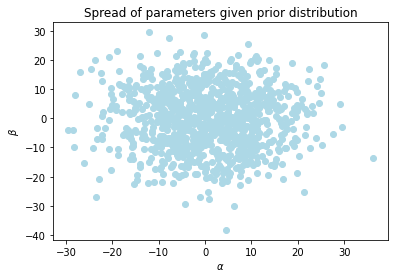

In [27]:
plt.scatter(alpha, beta, color='lightblue')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('Spread of parameters given prior distribution')
plt.show()

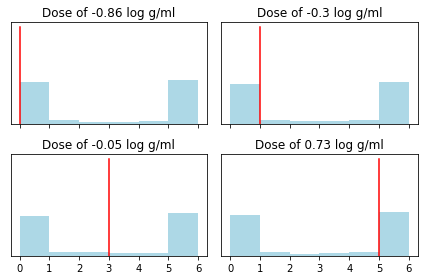

In [28]:
fig, axes = plt.subplots(2, 2, sharex=True,sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(4):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k],bins=[0,1,2,3,4,5,6], color='lightblue', density=True)
    ax.set_title(f'Dose of {x[k]} log g/ml')
    ax.plot([y[k],y[k]],[0,1],linestyle='-',color='red')
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

Number of predicted deaths is consistent with actual number of deaths in 3 out of 4 cases, and for dose of -0.05 log g/ml actual number of deaths is also possible with the priors 

#### Getting posterior distribution

Stan model for inference:

In [23]:
with open('posterior_inference.stan') as f:
    print(f.read())

data {
  int M;
  int N[M];
  real X[M];
  int y[M];
}
parameters {
  real alpha;
  real beta;
}

transformed parameters {
  vector[M] theta;
  for (k in 1:M) {
    theta[k] = inv_logit(alpha+beta*X[k]);
  }
}

model {
  target += student_t_lpdf(alpha|5,0,10);
  target += student_t_lpdf(beta|5,0,10);
  for (k in 1:M) {
    target += binomial_lpmf(y[k]|N[k],theta[k]);
  }
}

generated quantities {
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = binomial_rng(N[k],theta[k]);
  }
}


In [24]:
model = CmdStanModel(stan_file='posterior_inference.stan')

INFO:cmdstanpy:compiling stan program, exe file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab4/posterior_inference
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/jaqb/Documents/stan/Data-Analytics-Course/lab4/posterior_inference


In [25]:
data = dict(M=len(x), N=n, X=x, y=y)
model_fit = model.sample(data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


In [29]:
alpha_fit = model_fit.stan_variable('alpha')
beta_fit = model_fit.stan_variable('beta')

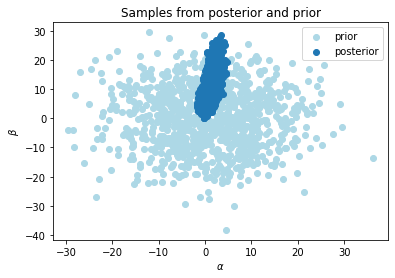

In [34]:
plt.scatter(alpha, beta, color='lightblue')
plt.scatter(alpha_fit, beta_fit)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('Samples from posterior and prior')
plt.legend(['prior', 'posterior'])
plt.show()

Samples from posterior are consistent with the prior.

#### Posterior predictive checks

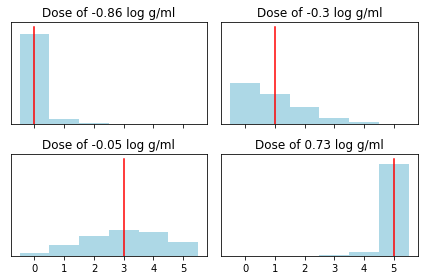

In [39]:
y_sim=model_fit.stan_variable('y_sim')
fig, axes = plt.subplots(2, 2, sharex=True,sharey=True,squeeze=False)
axes_flat=axes.flatten()
for k in range(4):
    ax = axes_flat[k]
    ax.hist(y_sim[:,k], color='lightblue', bins=np.linspace(-0.5,5.5,7), density=True)
    ax.plot([y[k],y[k]],[0,1],linestyle='-',color='red')
    ax.set_title('Dose of '+str(x[k])+' log g/ml')
    ax.set_xticks([0,1,2,3,4,5])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

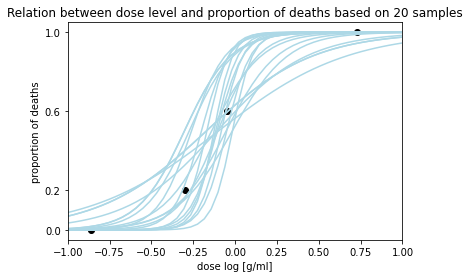

In [64]:
xs = np.linspace(-1, 1)
fs = expit(alpha_fit[:, None] + beta_fit[:, None]*xs)

plt.plot(xs, fs[:20].T, color='lightblue')
plt.scatter(x, y/n, color='black')
plt.xlim((-1, 1))
plt.ylabel('proportion of deaths')
plt.xlabel('dose log [g/ml]')
plt.title('Relation between dose level and proportion of deaths based on 20 samples')
plt.yticks(y/n)
plt.show()

#### Finding LD50
LD50 is the dose level at which the probability of death is 50%
$$\textrm{logit}^{-1}(\alpha + \beta x_{LD50})=0.5$$
$$x_{LD50}=\frac{\textrm{logit}(0.5)-\alpha}{\beta}$$

In [76]:
from scipy.special import logit
xLD50 = (logit(0.5)-alpha_fit)/beta_fit

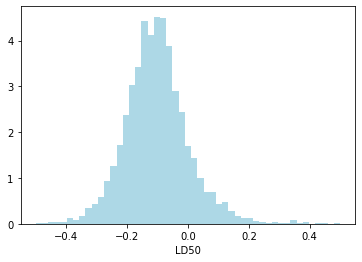

In [80]:
plt.hist(x50, bins=np.linspace(-0.5,0.5), color='lightblue', density=True)
plt.xlabel('LD50')
plt.show()